In [38]:
import os
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
np.random.seed(42)
import requests, zipfile, io
from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import seaborn as sn
import matplotlib.pyplot as plt


# IIA Data Challenge 3: Introducing the Data Set


## Predictive Dashboard: Publishing Estimated RUL of Jet Engines

### Sumit Dhar | Matt Mitchell

#### Date: October 27th 2020,


# Data Set Introduction

- The challenge datasets consist of multiple multivariate time series collected via dynamical simulation engine system. 
- The model simulated various degradation scenarios in any of the five rotating components of a engine (fan, LPC, HPC, HPT, and LPT), and the connections among the engine modules. 
- The engine begins in normal operation, then, degradation appears in some cycle of the simulation. 
- The degradation data for each engine are recorded until the engine fails. 
- The simulation model results in 218 engine datasets defined as unit 1 through unit 218 with different failure times measured by operating cycles

## Variables in Data

| Index	| Symbol | Description | Unit |
| --- | --- | --- | --- |
| 1	| T2 | Total | temperature at fan inlet | °R |
| 2	| T24 | Total temperature at LPC outlet | °R |
| 3	| T30 | Total temperature at HPC outlet | °R |
| 4	| T50 | Total temperature at LPT outlet | °R |
| 5	| P2 | Pressure at fan inlet | psia |
| 6	| P15 | Total pressure in bypass-duct | psia |
| 7	| P30 | Total pressure at HPC outlet | psia |
| 8	| Nf | Physical fan speed | rpm |
| 9	| Nc | Physical core speed | rpm |
| 10 | epr | Engine pressure ratio (P50/P2) | — |
| 11 | Ps30 | Static pressure at HPC outlet | psia |
| 12 | phi | Ratio of fuel flow to Ps30 | pps/psi |
| 13 | NRf | Corrected fan speed | rpm |
| 14 | NRc | Corrected core speed | rpm |
| 15 | BPR | Bypass ratio | — |
| 16 | farB | Burner fuel-air ratio | — |
| 17 | htBleed | Bleed enthalpy | — |
| 18 | Nf_dmd | Demanded fan speed | rpm |
| 19 | PCNFR_dmd | Demanded corrected fan speed | rpm |
| 20 | W31	HPT | coolant bleed | lbm/s |
| 21 | W32	LPT | coolant bleed | lbm/s |

In [39]:
df1 = pd.read_csv('train_FD001.txt', parse_dates=False, delimiter=" ", decimal=".", header=None)
df2 = pd.read_csv('train_FD002.txt', parse_dates=False, delimiter=" ", decimal=".", header=None)
df3 = pd.read_csv('train_FD003.txt', parse_dates=False, delimiter=" ", decimal=".", header=None)

# Variables Selected

- unit
- cycles
- 3 Operating Settings variables
- 21 sensor variables from s1..s21


In [78]:
cols = ['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
for df in [df1, df2, df3]:
    df.drop(df.columns[list(df.columns[df.isnull().sum() > 0])], axis=1, inplace=True)
    df.columns = cols

# Takeaway 1: Not All Variables are Equal

In [68]:
var_lst= []
threshold= [.00000000001, .00000001, 0.0001,.001,.01,.1]
for t in threshold:
    var_lst.append(len(df.columns[df.var()> t]))
    
logt = [-np.log10(t) for t in threshold]

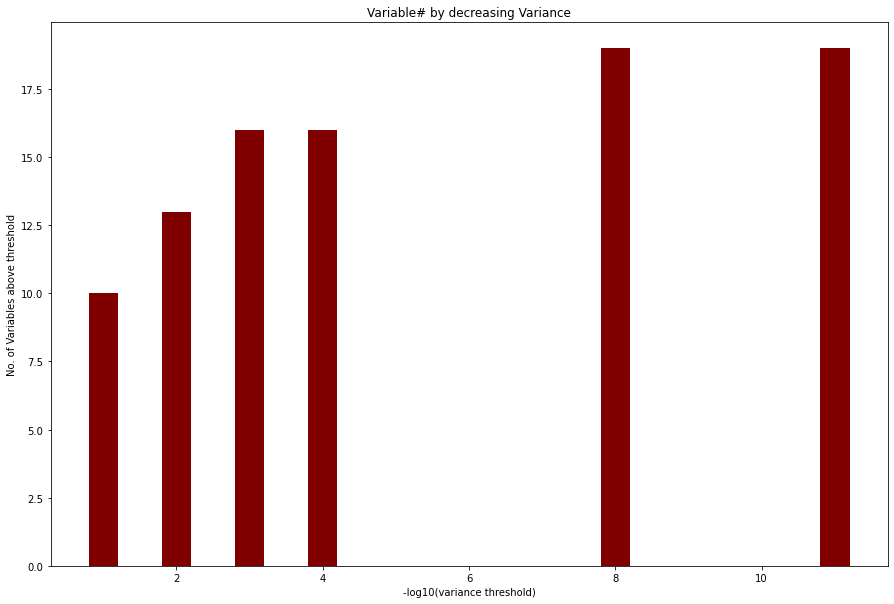

In [71]:
fig = plt.figure(figsize = (15, 10)) 
plt.bar(logt, var_lst, color ='maroon',  width = 0.4) 
plt.xlabel("-log10(variance threshold)") 
plt.ylabel("No. of Variables above threshold") 
plt.title("Variable# by decreasing Variance") 
plt.show() 

In [52]:
var_lst

[23, 16, 16, 13, 10]

# Takeaway 2: Bunch of Time Series | Different Units & Sensor S7

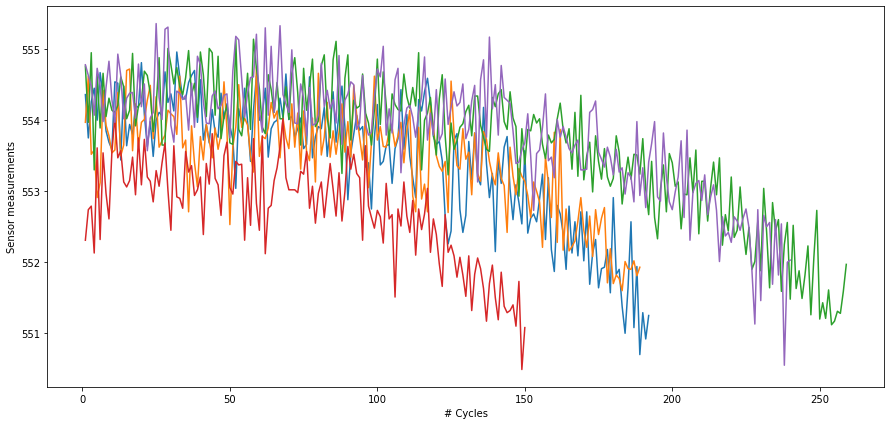

In [93]:
plt.figure(figsize = (15, 7))
plt.plot(df1[df1.unit==1].cycles, df1[df1.unit==1].s7)
plt.plot(df1[df1.unit==4].cycles, df1[df1.unit==4].s7)
plt.plot(df1[df1.unit==7].cycles, df1[df1.unit==7].s7)
plt.plot(df1[df1.unit==8].cycles, df1[df1.unit==8].s7)
plt.plot(df1[df1.unit==11].cycles, df1[df1.unit==11].s7)
plt.xlabel('# Cycles')
plt.ylabel('Sensor measurements')
plt.show()

# Takeaway 3: Bunch of Time Series | One Unit Different Sensor

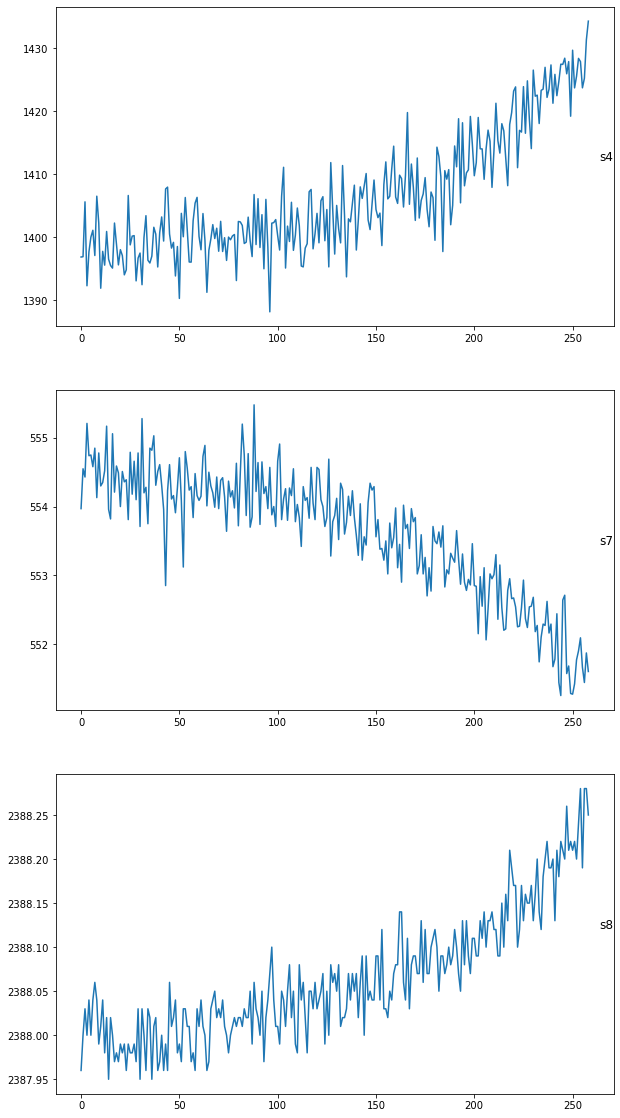

In [97]:
values = df[df.unit==1].values
groups = [8,11,12]
i = 1
plt.figure(figsize=(10,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [23]:
df = pd.merge(df, df.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
df.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
df['TTF'] = df['maxcycles'] - df['cycles']
df['TTF_pct'] = df['TTF'].divide(df['maxcycles']).round(2)

# Takeaway 4: Large Variation in Engine Performance

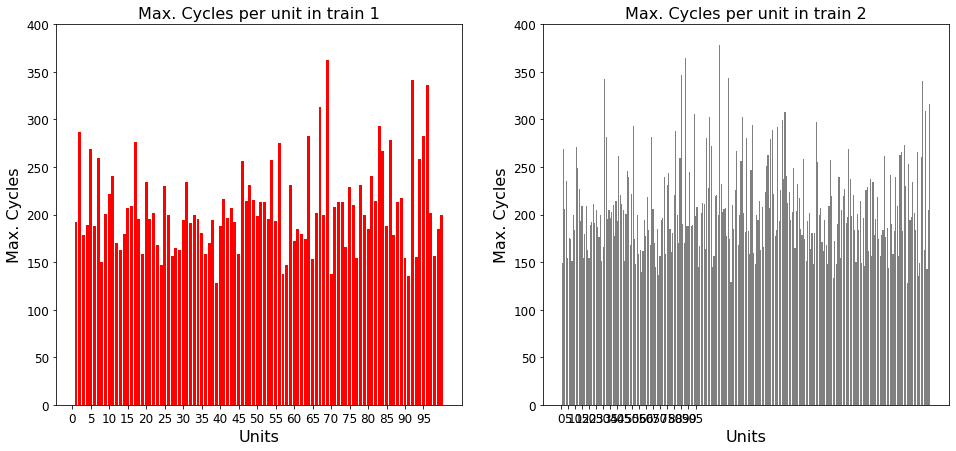

In [98]:
fig = plt.figure(figsize = (16,7))
fig.add_subplot(1,2,1)
bar_labels = list(df1['unit'])
bars = plt.bar(list(df1['unit']), df1['cycles'], color='red')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max. Cycles', fontsize=16)
plt.title('Max. Cycles per unit in train 1', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
fig.add_subplot(1,2,2)
bars = plt.bar(list(df2['unit']), df2['cycles'], color='grey')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max. Cycles', fontsize=16)
plt.title('Max. Cycles per unit in train 2', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Takeaway 5: Engine sensor's are differentiating

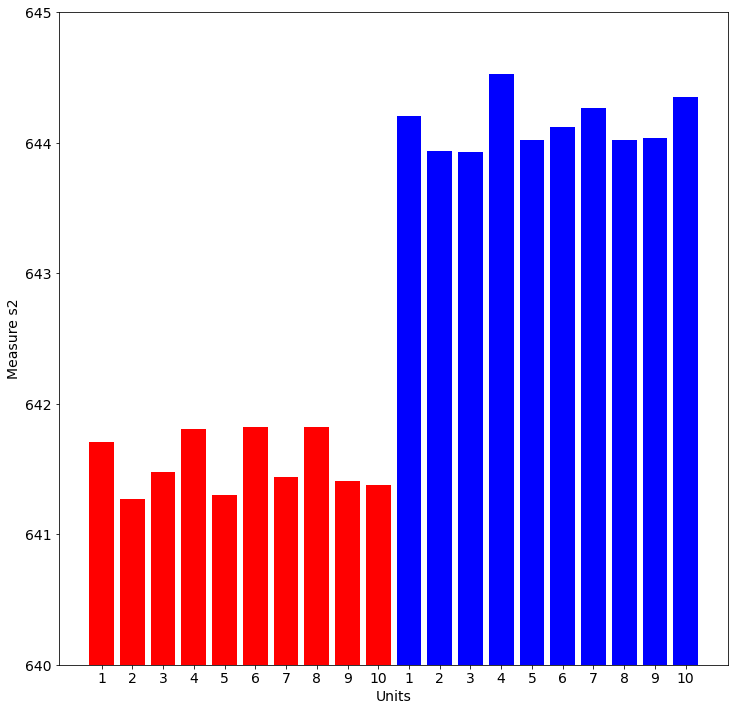

In [85]:
minb = df1.groupby('unit', as_index=False).min().head(10)
maxb = df1.groupby('unit', as_index=False).max().head(10)
mmtable = minb.append(maxb, ignore_index=True)
plt.figure(figsize = (12,12))
col = np.concatenate((np.repeat('red', 10), np.repeat('blue', 10)), axis=0)
bar_labels = list(mmtable['unit'])
x_pos = list(range(len(bar_labels)))
bars = plt.bar(x_pos, mmtable['s2'], color=col)
plt.ylim([640, 645])
plt.xlabel('Units', fontsize=14)
plt.ylabel('Measure s2', fontsize=14)
plt.xticks(x_pos, bar_labels, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Possible Predictive Treatments
- Use Operating Settings Sensor Data based on EDA for prediction

## As a Regression Problem

- What is the remaining useful life (RUL) in the jet engine?
- GLM/ Deep Learning Models

## As a Classification Problem

- What is the probability of failure of a jet engine at cycle 'C' in the next 'c' cycle of operation 
- Logistic Regression/ Tree  models

## As a Survival Problem

 - What is the probability of survival at a certain cycle using aggregated event sequenced data as a input to survival regression problem
 - Multivariate Survival Regression

# !! Watch Out !!

1. Choose a Quality metric and follow through the entire life cyle to optimize it
2. Avoid Leakage variables
    - Don't break causality. You are in effect tryign to estimate a function __f(X)__ that gives a estimate of __y__ in the form of __yhat__
    - Overfitting won't generalize well
    - Example:- 'Last 30 RUL Flag' is dependent on the end life of a jet engine
3. Robustness: Decide how you want to undertake cross-validation & testing
    - Familiarize with bias- variance trade off
4. Make it easy, pertinent and actionable for air operations
5. You have 3 sets of data set; make use of them to formulate and validate the prediction